In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics as stats
import pylab as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso        # regularizacion L1
from sklearn.linear_model import Ridge        # regularizacion L2
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RFR  
from sklearn.tree import ExtraTreeRegressor as ETR
#%pip install xgboost
#%pip install catboost
#%pip install lightgbm
from sklearn.ensemble import GradientBoostingRegressor as GBR
from xgboost import XGBRegressor as XGBR
from catboost import CatBoostRegressor as CTR

In [2]:
salaries_ori = pd.read_csv('data/salaries_data.csv')
sal = salaries_ori.copy()

In [3]:
testeo_ori = pd.read_csv('data/testeo.csv')
test = testeo_ori.copy()
test.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,employee_residence,remote_ratio,company_location,company_size
0,2020,SE,FT,Machine Learning Scientist,260000,USD,JP,0,JP,S
1,2020,MI,FT,Lead Data Analyst,87000,USD,US,100,US,L
2,2020,MI,FT,Data Analyst,85000,USD,US,100,US,L
3,2020,MI,FT,Machine Learning Engineer,299000,CNY,CN,0,CN,M
4,2020,MI,FT,Product Data Analyst,450000,INR,IN,100,IN,L


Lo primero navegamos por la bbdd y vemos qué datos hay.
- Revisamos si hay nulos (no hay)
- Revisamos si hay que modificar algunos type (están bien etiquetados)
- Revisamos si hay gran cantidad de datos duplicados


In [4]:
sal.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2022,SE,FT,Data Engineer,140250,USD,140250,US,100,US,M
1,2022,SE,FT,Data Engineer,135000,USD,135000,US,100,US,M
2,2021,MI,FT,BI Data Analyst,100000,USD,100000,US,100,US,M
3,2021,MI,CT,ML Engineer,270000,USD,270000,US,100,US,L
4,2021,MI,FT,Data Engineer,22000,EUR,26005,RO,0,US,L


In [5]:
sal.shape

(500, 11)

In [6]:
sal.employment_type.value_counts()

FT    484
PT      8
CT      4
FL      4
Name: employment_type, dtype: int64

In [7]:
sal.loc[sal['employment_type'] == 'FL']

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
21,2021,MI,FL,Machine Learning Scientist,12000,USD,12000,PK,50,PK,M
46,2021,MI,FL,Data Engineer,20000,USD,20000,IT,0,US,L
176,2020,SE,FL,Computer Vision Engineer,60000,USD,60000,RU,100,US,S
326,2022,MI,FL,Data Scientist,100000,USD,100000,CA,100,US,M


In [8]:
sal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           500 non-null    int64 
 1   experience_level    500 non-null    object
 2   employment_type     500 non-null    object
 3   job_title           500 non-null    object
 4   salary              500 non-null    int64 
 5   salary_currency     500 non-null    object
 6   salary_in_usd       500 non-null    int64 
 7   employee_residence  500 non-null    object
 8   remote_ratio        500 non-null    int64 
 9   company_location    500 non-null    object
 10  company_size        500 non-null    object
dtypes: int64(4), object(7)
memory usage: 43.1+ KB


In [9]:
sal.duplicated().sum()

34

Decidimos no eliminar los duplicados ya que no hay una gran cantidad y para entrenar los modelos predictivos, es interesante contar con la mayor cantidad de datos posible.

Una vez revisada la bbdd, vamos a analizar las columnas.
- la importancia de las columnas en la explicación de salary

In [10]:
sal['experience_level'] =LabelEncoder().fit_transform(sal.experience_level)
test['experience_level'] =LabelEncoder().fit_transform(test.experience_level)

In [11]:
sal['employment_type'] =LabelEncoder().fit_transform(sal.employment_type)
test['employment_type'] =LabelEncoder().fit_transform(test.employment_type)

In [12]:
sal['salary_currency'] =LabelEncoder().fit_transform(sal.salary_currency)
test['salary_currency'] =LabelEncoder().fit_transform(test.salary_currency)

In [13]:
sal['employee_residence'] =LabelEncoder().fit_transform(sal.employee_residence)
test['employee_residence'] =LabelEncoder().fit_transform(test.employee_residence)

In [14]:
sal['company_location'] =LabelEncoder().fit_transform(sal.company_location)
test['company_location'] =LabelEncoder().fit_transform(test.company_location)

In [15]:
sal['company_size'] =LabelEncoder().fit_transform(sal.company_size)
test['company_size'] =LabelEncoder().fit_transform(test.company_size)

In [16]:
sal['job_title'] = LabelEncoder().fit_transform(sal.job_title)
test['job_title'] = LabelEncoder().fit_transform(test.job_title)

In [17]:
sal.shape

(500, 11)

In [18]:
sal.salary_in_usd.describe()

count       500.000000
mean     112996.216000
std       69613.750601
min        2859.000000
25%       64594.500000
50%      103080.000000
75%      150000.000000
max      450000.000000
Name: salary_in_usd, dtype: float64

In [19]:
sal.salary_in_usd.median()

103080.0

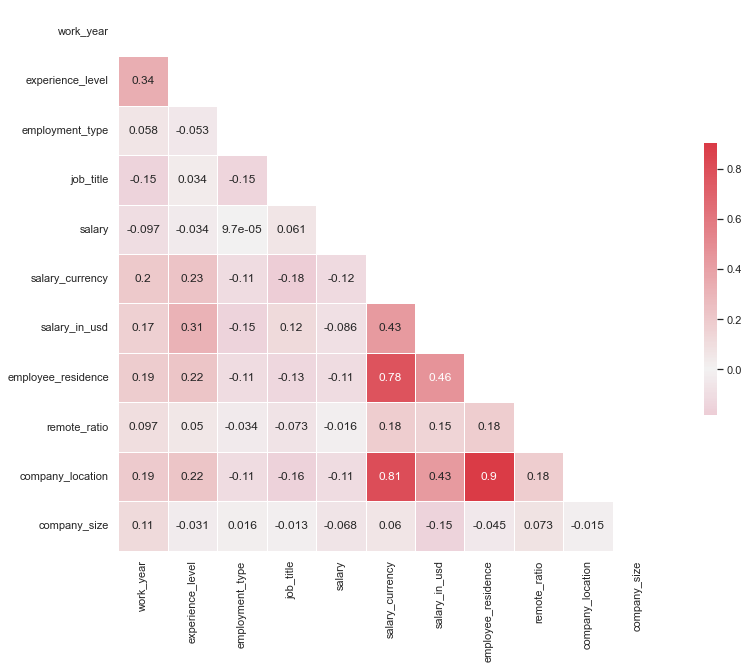

In [20]:
# buscando colinealidad

plt.figure(figsize=(15, 10))

sns.set(style='white')

mask=np.triu(np.ones_like(sal.corr(), dtype=bool))

cmap=sns.diverging_palette(0, 10, as_cmap=True)


sns.heatmap(sal.corr(),
           mask=mask,
          cmap=cmap,
          center=0,
          square=True,
          annot=True,
          linewidths=0.5,
          cbar_kws={'shrink': 0.5});

Tras ver qué relaciones tienen las columnas entre si, vamos a proceder a normalizar y hacer predición con regresión lineal para conocer el peso de las diferentes variables en la explicación del salario.

In [21]:
sal_num = sal.drop(columns=['salary','salary_in_usd'])
test_num = test.drop(columns=['salary'])

In [22]:
sal_num.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary_currency', 'employee_residence', 'remote_ratio',
       'company_location', 'company_size'],
      dtype='object')

In [23]:
columns=['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary_currency', 'employee_residence', 'remote_ratio',
       'company_location', 'company_size']

In [24]:
scaler=StandardScaler()

sal_num[columns]= scaler.fit_transform(sal_num[columns])

test_num[columns]= scaler.fit_transform(test_num[columns])

In [25]:
y = sal['salary_in_usd']

In [26]:
X_train, X_test, y_train, y_test = tts(sal_num, y, train_size=0.8, test_size=0.2, random_state=22)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 9), (100, 9), (400,), (100,))

In [27]:
def prediction():
    errores = []
    h = [LinReg(), Lasso(), Ridge(), ElasticNet(), SVR(), RFR(), ETR(), GBR(), XGBR(), CTR()]
    modelos=['linreg', 'lasso', 'ridge', 'elastic', 'svr', 'rfr', 'etr', 'gbr', 'xgbr', 'ctr']
    for i, m in enumerate (modelos):
        m = h[i]
        m.fit(X_train, y_train)
        m.predict(X_test)
        y_pred = m.predict(X_test)
        errores.append(f'{m}: {mse(y_test, y_pred, squared=False)}')
    return errores

In [28]:
prediction()

Learning rate set to 0.035425
0:	learn: 71358.6281736	total: 61ms	remaining: 1m
1:	learn: 70482.4005801	total: 61.5ms	remaining: 30.7s
2:	learn: 69734.2948530	total: 61.8ms	remaining: 20.5s
3:	learn: 68976.7773271	total: 62.2ms	remaining: 15.5s
4:	learn: 68268.1145555	total: 62.7ms	remaining: 12.5s
5:	learn: 67508.0722911	total: 63ms	remaining: 10.4s
6:	learn: 66778.7931709	total: 64.1ms	remaining: 9.09s
7:	learn: 66246.6521689	total: 64.2ms	remaining: 7.96s
8:	learn: 65644.7170294	total: 64.5ms	remaining: 7.11s
9:	learn: 65104.9860053	total: 64.9ms	remaining: 6.43s
10:	learn: 64431.7005215	total: 65.6ms	remaining: 5.9s
11:	learn: 63837.4065942	total: 65.8ms	remaining: 5.42s
12:	learn: 63237.1561318	total: 66.2ms	remaining: 5.02s
13:	learn: 62641.1600704	total: 66.5ms	remaining: 4.68s
14:	learn: 62052.1820214	total: 66.7ms	remaining: 4.38s
15:	learn: 61510.8329039	total: 67.1ms	remaining: 4.13s
16:	learn: 61032.0439189	total: 67.3ms	remaining: 3.89s
17:	learn: 60547.3008655	total: 67.6

277:	learn: 36019.2580204	total: 174ms	remaining: 453ms
278:	learn: 36002.5191246	total: 175ms	remaining: 452ms
279:	learn: 35955.9851538	total: 175ms	remaining: 451ms
280:	learn: 35951.2456644	total: 176ms	remaining: 450ms
281:	learn: 35923.4366475	total: 176ms	remaining: 449ms
282:	learn: 35905.2742215	total: 177ms	remaining: 448ms
283:	learn: 35861.7343615	total: 177ms	remaining: 447ms
284:	learn: 35822.1108501	total: 177ms	remaining: 445ms
285:	learn: 35813.4817089	total: 178ms	remaining: 444ms
286:	learn: 35794.5123033	total: 178ms	remaining: 442ms
287:	learn: 35743.0841096	total: 179ms	remaining: 441ms
288:	learn: 35715.3684957	total: 179ms	remaining: 440ms
289:	learn: 35685.0453966	total: 179ms	remaining: 439ms
290:	learn: 35655.6939367	total: 180ms	remaining: 438ms
291:	learn: 35618.3566395	total: 180ms	remaining: 436ms
292:	learn: 35552.5958891	total: 180ms	remaining: 435ms
293:	learn: 35508.1134167	total: 181ms	remaining: 434ms
294:	learn: 35461.4528859	total: 181ms	remaining

746:	learn: 28257.9005708	total: 353ms	remaining: 119ms
747:	learn: 28238.7093155	total: 353ms	remaining: 119ms
748:	learn: 28225.4168299	total: 354ms	remaining: 119ms
749:	learn: 28210.0359889	total: 354ms	remaining: 118ms
750:	learn: 28203.1506475	total: 354ms	remaining: 118ms
751:	learn: 28193.5125956	total: 355ms	remaining: 117ms
752:	learn: 28183.8753334	total: 355ms	remaining: 117ms
753:	learn: 28171.9749779	total: 356ms	remaining: 116ms
754:	learn: 28144.3826544	total: 356ms	remaining: 116ms
755:	learn: 28134.9052829	total: 357ms	remaining: 115ms
756:	learn: 28134.4350557	total: 357ms	remaining: 115ms
757:	learn: 28121.6130996	total: 357ms	remaining: 114ms
758:	learn: 28117.9686181	total: 358ms	remaining: 114ms
759:	learn: 28104.9403405	total: 358ms	remaining: 113ms
760:	learn: 28090.9172448	total: 358ms	remaining: 113ms
761:	learn: 28086.6296783	total: 359ms	remaining: 112ms
762:	learn: 28075.7173602	total: 359ms	remaining: 112ms
763:	learn: 28071.7815716	total: 359ms	remaining

['LinearRegression(): 43859.120710021096',
 'Lasso(): 43858.5048520941',
 'Ridge(): 43841.743285883225',
 'ElasticNet(): 44388.99806425408',
 'SVR(): 56414.60765685414',
 'RandomForestRegressor(): 34639.5950071078',
 'ExtraTreeRegressor(): 50468.4472568863',
 'GradientBoostingRegressor(): 37660.637609747464',
 "XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,\n             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n             early_stopping_rounds=None, enable_categorical=False,\n             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,\n             grow_policy='depthwise', importance_type=None,\n             interaction_constraints='', learning_rate=0.300000012, max_bin=256,\n             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,\n             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,\n             monotone_constraints='()', n_estimators=100, n_jobs=0,\n             num_parallel_tree=1, predictor='au

In [29]:
# entrenar 100
# hacer todos los cambios en testeo
# y predecir con muestra
# guardar predicción en columna
# eliminar el resto de columnas de muestra para que quede id y prección y subir a kaggle

Ahora hacemos la predicción con la bbdd de testeo:

In [30]:
X_train = sal_num
y_train = sal.salary_in_usd

In [31]:
X_test = test_num

In [32]:
rfr=RFR()
rfr.fit(X_train, y_train)
test['salary_in_usd'] = rfr.predict(X_test)

In [33]:
test.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary_in_usd
0,2020,3,1,22,260000,11,17,0,18,2,125029.195000
1,2020,2,1,18,87000,11,25,100,23,0,332720.000000
2,2020,2,1,8,85000,11,25,100,23,0,97596.833333
3,2020,2,1,20,299000,2,4,0,4,1,101708.850000
4,2020,2,1,27,450000,7,14,100,15,0,47755.954500


In [34]:
test = test.reset_index()

In [35]:
test.columns

Index(['index', 'work_year', 'experience_level', 'employment_type',
       'job_title', 'salary', 'salary_currency', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size', 'salary_in_usd'],
      dtype='object')

In [37]:
test_final = test.drop(columns= ['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'employee_residence', 'remote_ratio',
       'company_location', 'company_size'])

In [38]:
test_final.columns = ['id','salary_in_usd']

In [40]:
test_final.head()

,id,salary_in_usd
0,0,125029.195000
1,1,332720.000000
2,2,97596.833333
3,3,101708.850000
4,4,47755.954500


In [42]:
test_final.to_csv('data/prediccion.csv', index=False)